In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from dataset import MuticlassImageSegmentationDataset
import pandas as pd
from torch.utils.data import DataLoader
# torch datset splotter
from sklearn.model_selection import train_test_split
# torch metrics
import torchvision

from torchviz import make_dot

In [8]:
class ConditionedConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, cond_size, kernel_size, stride=1, padding=0):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.cond1 = nn.Linear(cond_size, in_channels)
        self.cond2 = nn.Linear(cond_size, out_channels)
        
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)

    def forward(self, x, cond):
        cond1 = torch.sigmoid(self.cond1(cond))
        cond1 = cond1.unsqueeze(2).unsqueeze(3)
        cond1 = cond1.repeat(1, 1, x.shape[2], x.shape[3])
        out = self.conv(x * cond1)
        cond2 = torch.sigmoid(self.cond2(cond))
        cond2 = cond2.unsqueeze(2).unsqueeze(3)
        cond2 = cond2.repeat(1, 1, out.shape[2], out.shape[3])
        return out * cond2
    

In [9]:


from torch.utils.tensorboard import SummaryWriter
test_conv = ConditionedConv2d(3, 16, 58, 3)
writer = SummaryWriter("graphs/")

imgtest = torch.rand(1, 3, 128, 128)
condtest = torch.rand(1, 58)

writer.add_graph(test_conv, (imgtest, condtest))


In [10]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, cond_size):
        super().__init__()
        self.conv1 = ConditionedConv2d(in_channels, out_channels, cond_size, 3, padding=1)
        self.conv2 = ConditionedConv2d(out_channels, out_channels, cond_size, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x, cond):
        x = self.conv1(x, cond)
        x = self.bn1(x)
        x = F.gelu(x)
        x = self.conv2(x, cond)
        x = self.bn2(x)
        x = F.gelu(x)
        return x

In [11]:
class DownConv(nn.Module):
    def __init__(self, in_channels, out_channels, cond_size):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels, cond_size)
        self.pool = nn.MaxPool2d(2)

    def forward(self, x, cond):
        x = self.conv(x, cond)
        x = self.pool(x)
        return x

In [12]:
class UpConv(nn.Module):
    def __init__(self, in_channels, out_channels, cond_size):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = DoubleConv(in_channels, out_channels, cond_size)

    def forward(self, x1, x2, cond):
        x = torch.cat([x2, x1], dim=1)
        x = self.up(x)
        x = self.conv(x, cond)
        return x

In [13]:
class ConditionedUNet(nn.Module):
    def __init__(self, cond_size, cond_hidden_size):
        super().__init__()
        self.in_channels = 3
        self.out_channels = 1
        self.cond_size = cond_size
        self.cond_hidden_size = cond_hidden_size

        self.cond_fc = nn.Sequential(
            nn.Linear(self.cond_size, self.cond_hidden_size),
            nn.ReLU(),
            nn.Linear(self.cond_hidden_size, self.cond_hidden_size),
            nn.ReLU()
        )

        self.down1 = DownConv(self.in_channels, 32, self.cond_hidden_size)
        self.down2 = DownConv(32, 64, self.cond_hidden_size)
        self.down3 = DownConv(64, 128, self.cond_hidden_size)
        self.down4 = DownConv(128, 256, self.cond_hidden_size)
        
        self.bootleneck = DoubleConv(256, 256, self.cond_hidden_size)

        self.up1 = UpConv(512, 128, self.cond_hidden_size)
        self.up2 = UpConv(256, 64, self.cond_hidden_size)
        self.up3 = UpConv(128, 32, self.cond_hidden_size)
        self.up4 = UpConv(64, 16, self.cond_hidden_size)

        self.out = ConditionedConv2d(16, self.out_channels, self.cond_hidden_size, 1)

    def forward(self, x, cond):
        cond = self.cond_fc(cond)
        x1 = self.down1(x, cond)
        x2 = self.down2(x1, cond)
        x3 = self.down3(x2, cond)
        x4 = self.down4(x3, cond)
        x = self.bootleneck(x4, cond)
        x = self.up1(x, x4, cond)
        x = self.up2(x, x3, cond)
        x = self.up3(x, x2, cond)
        x = self.up4(x, x1, cond)
        x = self.out(x, cond)
        x = torch.sigmoid(x)
        return x

In [18]:


test_unet = ConditionedUNet(58, 128)

imgtest = torch.rand(1, 3, 128, 128)
condtest = torch.rand(1, 58)


In [7]:
class Model(pl.LightningModule):
    def __init__(self, cond_size, cond_hidden_size):
        super().__init__()
        self.model = ConditionedUNet(cond_size, cond_hidden_size)
        self.loss = nn.BCELoss()

    def forward(self, x, cond):
        return self.model(x, cond)
    
    def training_step(self, batch, batch_idx):
        x, y, cond = batch
        y_hat = self(x, cond)
        loss = self.loss(y_hat, y)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y, cond = batch

        y_hat = self(x, cond)
        loss = self.loss(y_hat, y)
        self.log('val_loss', loss)

        if batch_idx == 0:
            # expand to 3 channels
            y = y.repeat(1, 3, 1, 1)
            y_hat = y_hat.repeat(1, 3, 1, 1)

            grid = torchvision.utils.make_grid(torch.cat([x, y, y_hat], dim=0))
            self.logger.experiment.add_image('val_images', grid, self.current_epoch)

        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
        return {
            'optimizer': optimizer,
            'lr_scheduler': scheduler,
            'monitor': 'val_loss'
        }


In [8]:
single_masks = pd.read_csv('fashion_dataset/single_masks.csv', dtype={'image': str})

train_df, test_val_df = train_test_split(single_masks, test_size=0.2)
test_df, val_df = train_test_split(test_val_df, test_size=0.5)

In [9]:
train_ds = MuticlassImageSegmentationDataset('fashion_dataset/png_images/IMAGES', 'fashion_dataset/png_masks/MASKS', train_df, 58, 128)
val_ds = MuticlassImageSegmentationDataset('fashion_dataset/png_images/IMAGES', 'fashion_dataset/png_masks/MASKS', val_df, 58, 128)
test_ds = MuticlassImageSegmentationDataset('fashion_dataset/png_images/IMAGES', 'fashion_dataset/png_masks/MASKS', test_df, 58, 128)

In [10]:
len(train_ds), len(val_ds), len(test_ds)

(5793, 725, 724)

In [11]:
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=12)
val_dl = DataLoader(val_ds, batch_size=16, shuffle=False, num_workers=12)
test_dl = DataLoader(test_ds, batch_size=16, shuffle=False, num_workers=12)

In [12]:
model = Model(train_ds.no_clases, 128)

In [13]:
trainer = pl.Trainer(accelerator='gpu', devices=1, max_epochs=75, accumulate_grad_batches=4)
trainer.fit(model, train_dl, val_dl)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type            | Params
------------------------------------------
0 | model | ConditionedUNet | 3.9 M 
1 | loss  | BCELoss         | 0     
------------------------------------------
3.9 M     Trainable params
0         Non-trainable params
3.9 M     Total params
15.705    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=75` reached.


In [14]:
# save model
torch.save(model.state_dict(), 'model.pt')

In [15]:
x, y, cond = next(iter(test_dl))
y_hat = model(x, cond)

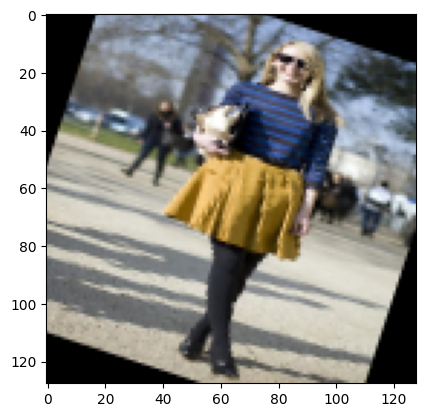

In [46]:
import matplotlib.pyplot as plt
plt.imshow(x[11].permute(1, 2, 0))
plt.show()


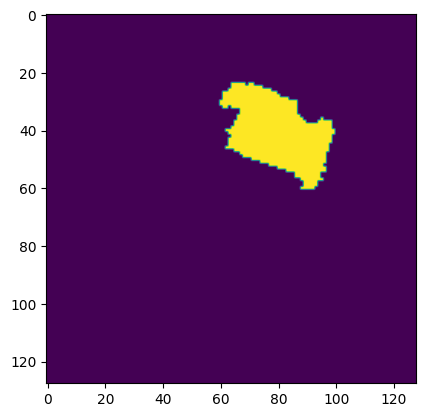

In [47]:
plt.imshow(y[11].squeeze())

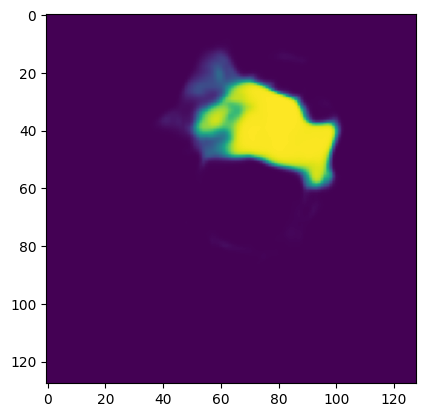

In [48]:
plt.imshow(y_hat[11][0].detach().cpu().numpy())